# Benchmark

In [ ]:
%pip install --upgrade https://github.com/remifan/commplax/archive/master.zip
%pip install --upgrade https://github.com/remifan/LabPtPTm2/archive/master.zip
%pip install --upgrade https://github.com/remifan/gdbp_study/archive/master.zip

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from functools import partial
import matplotlib.pyplot as plt

from commplax import util
from gdbp import gdbp_base as gb, data as gdat, aux

In [2]:
aux.dl_trained_params() # download pre-trained parameters
loc_trained_params = './trained_params/pretrained'

100% [..........................................................................] 1582928 / 1582928

In [3]:
LP = np.array([-4, -2, -1, 0, 1])  # launched power in dBm

# use Pandas.Dataframe to store the results
df_test_res = pd.DataFrame({c: pd.Series(dtype=t) for c, t in {'ChInd': 'int',
                                                               'LPdBm': 'float',
                                                               'Model': 'str',
                                                               'Q': 'float'}.items()})


# check `gdbp_study-master/src/gdbp_base.py` for model definition
def init_models(data: gdat.Input, **kwargs):
  ''' make CDC and DBP's derivatives
      (all methods has trainable R-filter)
      cdc:  static D-filter, no NLC
      dbp:  static D-filter, scalar manually optimized NLC factor
      fdbp: static D-filter, static N-filter scaled by manually optimized NLC factor
      edbp: static D-filter, tap-by-tap optimizable/trainable N-filter
      gdbp: tap-by-tap optimizable/trainable D-filter and N-filter
  '''
  
  mode  = kwargs.get('mode', 'train')
  steps = kwargs.get('steps', 3)
  dtaps = kwargs.get('dtaps', 261)
  ntaps = kwargs.get('ntaps', 41)
  rtaps = kwargs.get('rtaps', 61)
  xi    = kwargs.get('xi', 1.1) # optimal xi for FDBP
  
  fdbp_init = partial(gb.fdbp_init, data.a, steps=steps)
  model_init = partial(gb.model_init, data)
  
  comm_conf = {'mode': mode, 'steps': steps, 'dtaps': dtaps, 'rtaps': rtaps} # common configurations
  #     init. func.| define model structure parameters and some initial values    | define static modules    | identifier
  cdc  = model_init({**comm_conf, 'ntaps': 1,     'init_fn': fdbp_init(xi=0.0)},  [('fdbp_0',)],             name='CDC')
  dbp  = model_init({**comm_conf, 'ntaps': 1,     'init_fn': fdbp_init(xi=0.15)}, [('fdbp_0',)],             name='DBP')
  fdbp = model_init({**comm_conf, 'ntaps': ntaps, 'init_fn': fdbp_init(xi=xi)},   [('fdbp_0',)],             name='FDBP')
  edbp = model_init({**comm_conf, 'ntaps': ntaps, 'init_fn': fdbp_init(xi=xi)},   [('fdbp_0', r'DConv_\d')], name='EDBP')
  gdbp = model_init({**comm_conf, 'ntaps': ntaps, 'init_fn': fdbp_init(xi=xi)},   [],                        name='GDBP')
  
  return cdc, dbp, fdbp, edbp, gdbp


def load_data(ch: int):
  ''' build pairs of datasets for training and testing '''
  
  ds_train = gdat.load(1, LP, ch, 2)
  ds_test  = gdat.load(2, LP, ch, 1)
  return [(ds_tr, ds_te) for ds_tr, ds_te in zip(ds_train, ds_test)]


def sweep_channel(ch: int,
                  df_test_res=df_test_res,
                  use_pretrained_params=False,
                  save_params=False,
                  save_subdirname='regular_taps',
                  model_init_kwargs={}):
  ''' sweep launched power of given channel '''
  
  util.clear_xla_cache() # release JAX's cache to save RAM
                                  
  # iterate data of target channel
  for i, chds in enumerate(tqdm(load_data(ch),
                                desc=f'sweeping launch power on Ch#{ch}',
                                leave=False)):  
    ds_train, ds_test = chds
    models_train = init_models(ds_train, **model_init_kwargs)
    models_test  = init_models(ds_test, mode='test', **model_init_kwargs)
    
    # iterate models
    for j, (model_train, model_test) in enumerate(tqdm(zip(models_train, models_test),
                                                       desc='iterating models',
                                                       leave=False,
                                                       total=len(models_train))):
      params_file = os.path.join(loc_trained_params,
                                 'snr_vs_lp',
                                 save_subdirname,
                                 'params_%d_%d_%d' % (ch, i, j)) # params_{ch}_{lp}_{mod}
      
      if use_pretrained_params:
        params = util.load_variable(params_file)
      else:
        # use trained params of the 3rd last batch, as tailing samples are corrupted by CD
        params_queue = [None] * 3 
        
        # iterate the training steps
        for _, p, _ in gb.train(model_train, ds_train, n_iter=2000):
          params_queue.append(p)
          params = params_queue.pop(0)
          
        if save_params:
          util.save_variable(params, params_file)

      test_Q = gb.test(model_test, params, ds_test)[0].QSq.total
  
      # collect result
      df_test_res = df_test_res.append({'ChInd': ch,
                                        'LPdBm': ds_test.a['lpdbm'],
                                        'Model': model_test.name,
                                        'Q': test_Q},
                                       ignore_index=True)
    
  return df_test_res

In [3]:
# it may take a while to finish
kwargs = {'save_subdirname': 'regular_taps',
          'use_pretrained_params': True,     # use pretrained parameters to save time
          'save_params': False}              # save trained parameters after training

for ch in tqdm(1 + np.arange(7), desc='sweeping channels'):
  df_test_res = sweep_channel(ch, df_test_res, **kwargs)
  
df_test_res

sweeping channels:   0%|          | 0/7 [00:00<?, ?it/s]

loading data:   0%|          | 0/5 [00:00<?, ?it/s]

loading data:   0%|          | 0/5 [00:00<?, ?it/s]

sweeping launch power on Ch#1:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

loading data:   0%|          | 0/5 [00:00<?, ?it/s]

loading data:   0%|          | 0/5 [00:00<?, ?it/s]

sweeping launch power on Ch#2:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

loading data:   0%|          | 0/5 [00:00<?, ?it/s]

loading data:   0%|          | 0/5 [00:00<?, ?it/s]

sweeping launch power on Ch#3:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

loading data:   0%|          | 0/5 [00:00<?, ?it/s]

loading data:   0%|          | 0/5 [00:00<?, ?it/s]

sweeping launch power on Ch#4:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

loading data:   0%|          | 0/5 [00:00<?, ?it/s]

loading data:   0%|          | 0/5 [00:00<?, ?it/s]

sweeping launch power on Ch#5:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

loading data:   0%|          | 0/5 [00:00<?, ?it/s]

loading data:   0%|          | 0/5 [00:00<?, ?it/s]

sweeping launch power on Ch#6:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

loading data:   0%|          | 0/5 [00:00<?, ?it/s]

loading data:   0%|          | 0/5 [00:00<?, ?it/s]

sweeping launch power on Ch#7:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

,ChInd,LPdBm,Model,Q
0,1,-4.0,CDC,7.998095
1,1,-4.0,DBP,8.031192
2,1,-4.0,FDBP,8.088200
3,1,-4.0,EDBP,8.107054
4,1,-4.0,GDBP,8.152279
...,...,...,...,...
170,7,1.0,CDC,7.602585
171,7,1.0,DBP,7.864725
172,7,1.0,FDBP,8.450531
173,7,1.0,EDBP,8.609769


In [4]:
# save results
df_test_res.to_csv('benchmark_regular_taps.csv', index=False)

Now we visualize the results by manipulating the results table, see [Pandas.Dataframe](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html) for instructions.

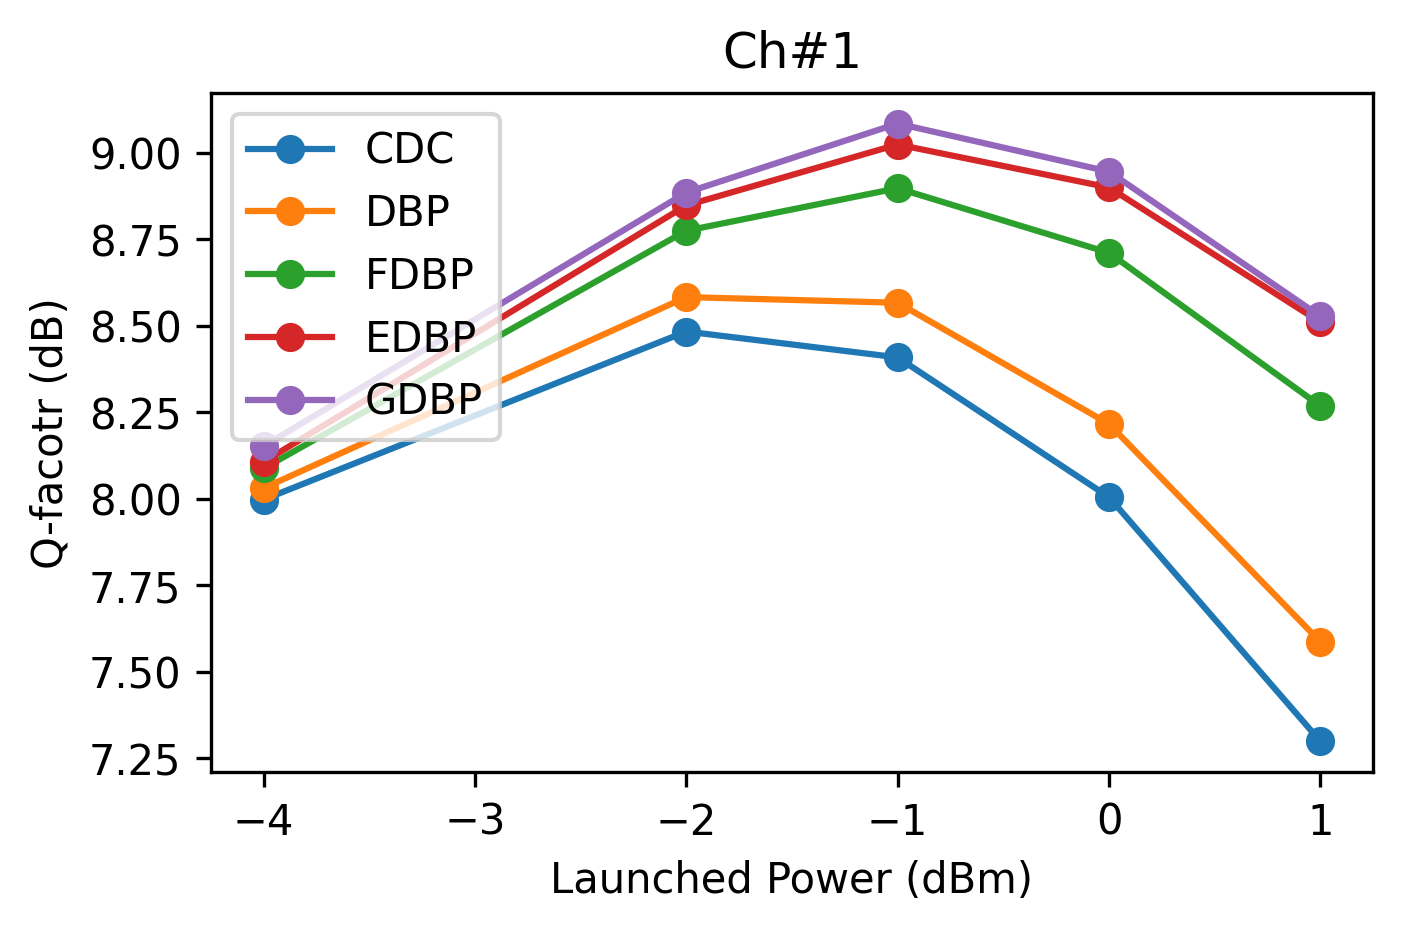

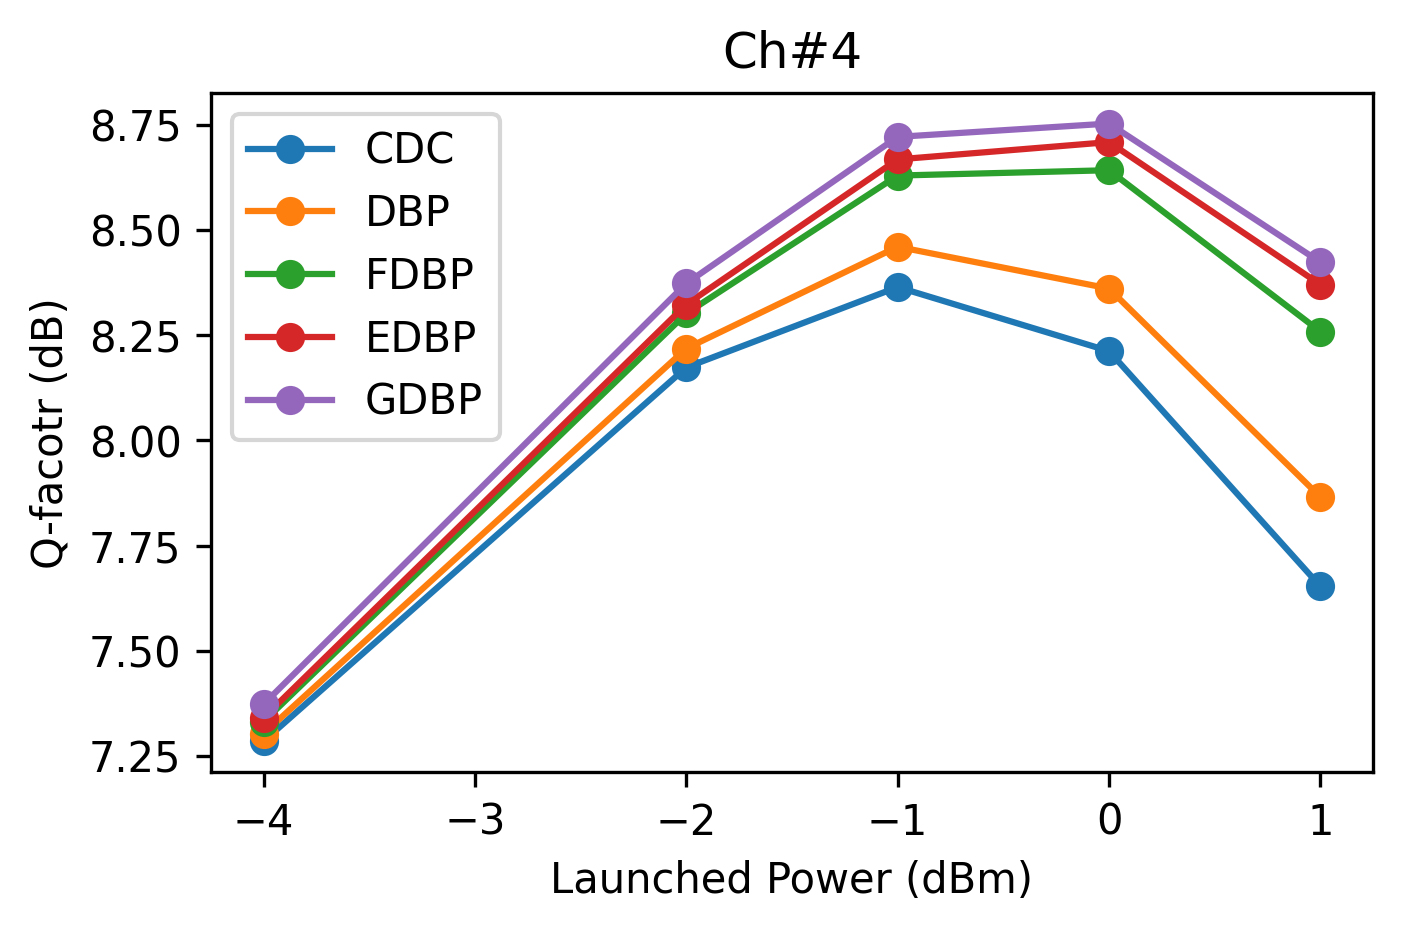

In [5]:
grp_ch = df_test_res.loc[df_test_res['ChInd'].isin([1, 4])].groupby('ChInd')

for n_ch, g_ch in grp_ch:
  fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
  
  for n_mod, g_mod in g_ch.groupby('Model', sort=False):
    ax.plot(g_mod.LPdBm, g_mod.Q, '-o', label=n_mod)
    
  ax.legend(loc='upper left')
  ax.set_title(f'Ch#{n_ch}')
  ax.set_xlabel('Launched Power (dBm)')
  ax.set_ylabel('Q-facotr (dB)')

Text(0.5, 1.0, 'Optimal $Q$-factor')

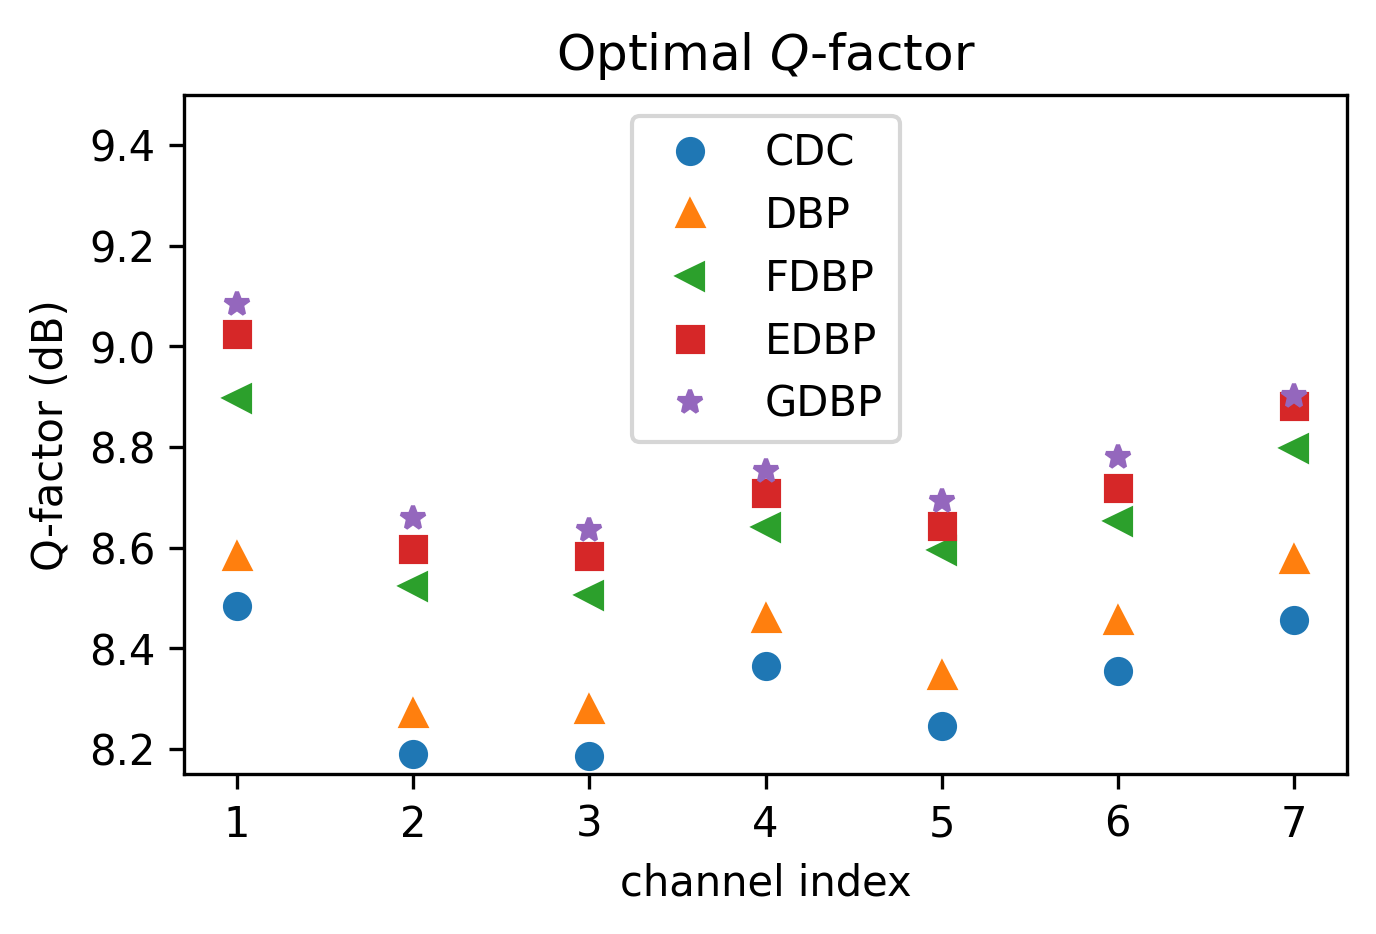

In [6]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
fmt = ['o', '^', '<', 's', '*']
grp_opt_Q = df_test_res.groupby(['ChInd', 'Model'], as_index=False, sort=False)['Q'] \
                       .max().groupby('Model', sort=False)
for f, (n, g) in zip(fmt, grp_opt_Q):
  ax.plot(g.ChInd, g.Q, f, label=n)
ax.legend()
ax.set_xlabel('channel index')
ax.set_ylabel('Q-factor (dB)')
ax.set_ylim([8.15, 9.5])
ax.set_title(r'Optimal $Q$-factor')

In [4]:
# it may take a while to finish
kwargs = {'save_subdirname': 'few_taps',
          'use_pretrained_params': True, # use pretrained parameters to save time
          'save_params': False,
          'model_init_kwargs': {'dtaps': 221, 'ntaps': 11, 'xi': 0.5}}


df_test_res_ft = sweep_channel(4, df_test_res, **kwargs)
df_test_res_ft

loading data:   0%|          | 0/5 [00:00<?, ?it/s]

loading data:   0%|          | 0/5 [00:00<?, ?it/s]

sweeping launch power on Ch#4:   0%|          | 0/5 [00:00<?, ?it/s]

iterating models:   0%|          | 0/5 [00:00<?, ?it/s]

iterating models:   0%|          | 0/5 [00:00<?, ?it/s]

iterating models:   0%|          | 0/5 [00:00<?, ?it/s]

iterating models:   0%|          | 0/5 [00:00<?, ?it/s]

iterating models:   0%|          | 0/5 [00:00<?, ?it/s]

,ChInd,LPdBm,Model,Q
0,4,-4.0,CDC,7.102697
1,4,-4.0,DBP,7.117552
2,4,-4.0,FDBP,7.124030
3,4,-4.0,EDBP,7.133463
4,4,-4.0,GDBP,7.332214
5,4,-2.0,CDC,7.933425
6,4,-2.0,DBP,7.982038
7,4,-2.0,FDBP,8.021433
8,4,-2.0,EDBP,8.050963
9,4,-2.0,GDBP,8.322369


Text(0, 0.5, 'Q-facotr (dB)')

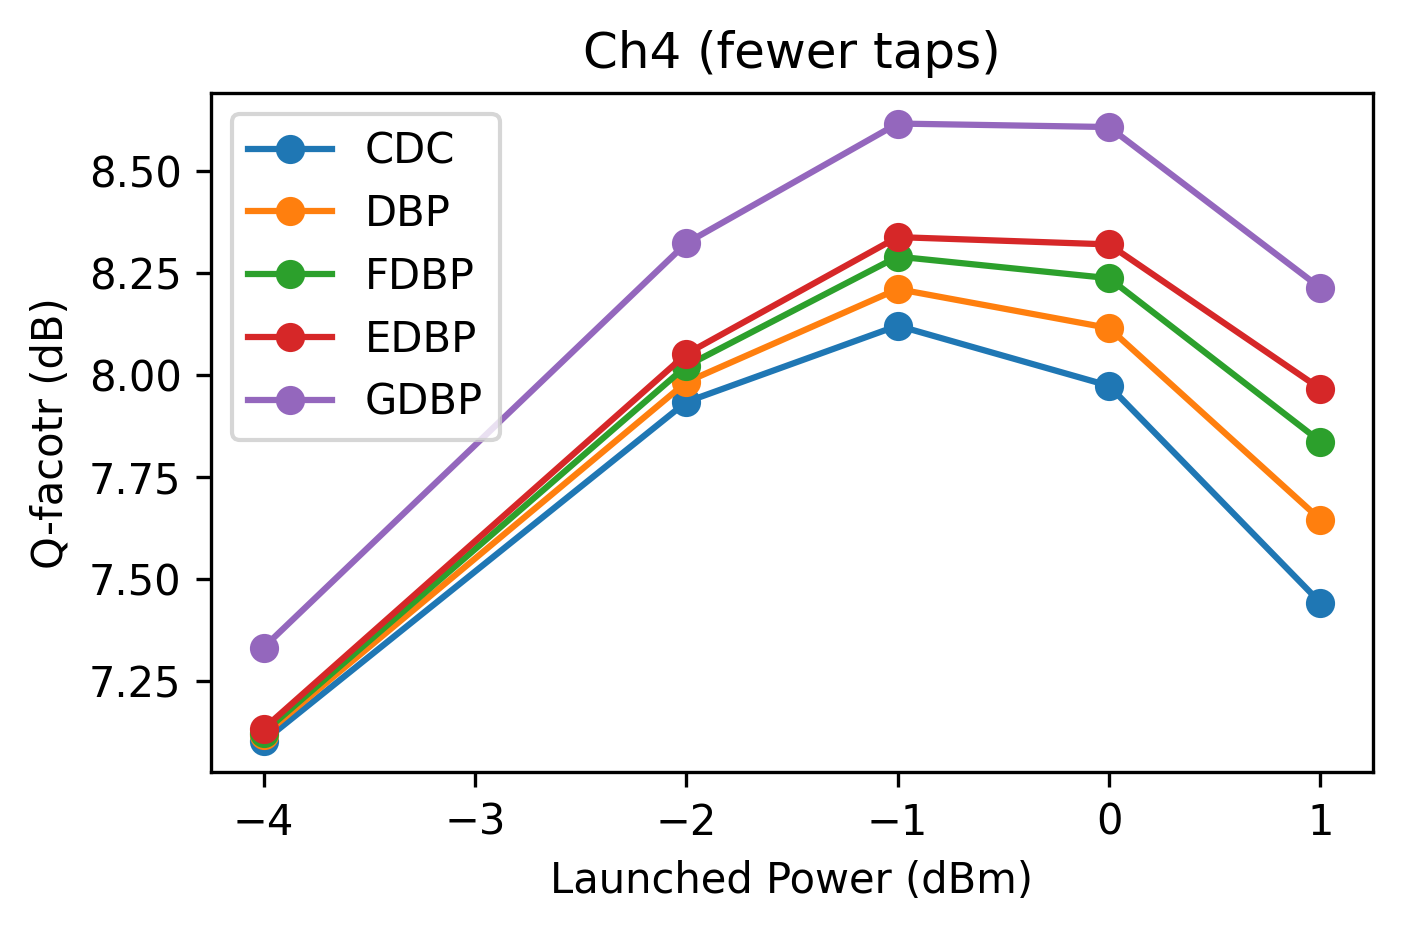

In [7]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
  
for n_mod, g_mod in df_test_res_ft.groupby('Model', sort=False):
  ax.plot(g_mod.LPdBm, g_mod.Q, '-o', label=n_mod)

ax.legend(loc='upper left')
ax.set_title(f'Ch4 (fewer taps)')
ax.set_xlabel('Launched Power (dBm)')
ax.set_ylabel('Q-facotr (dB)')